   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb   

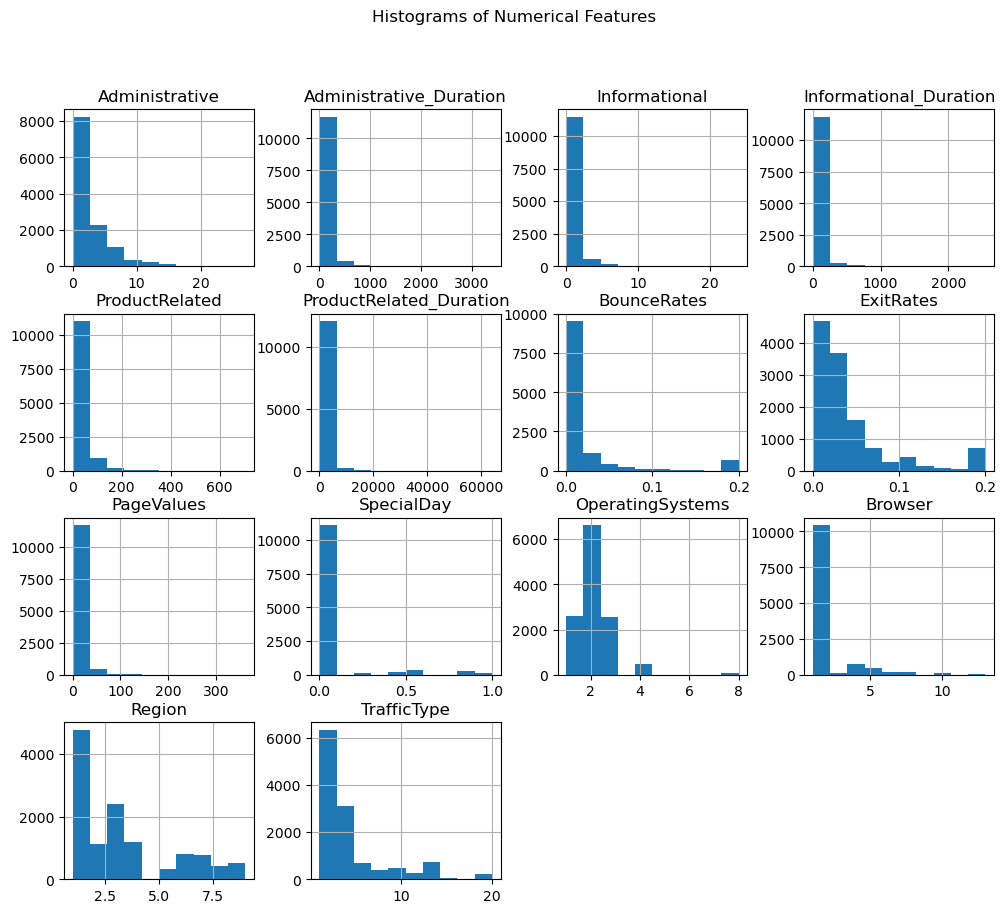

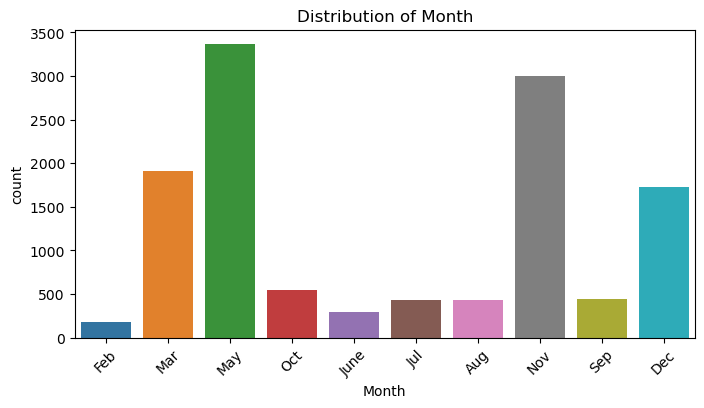

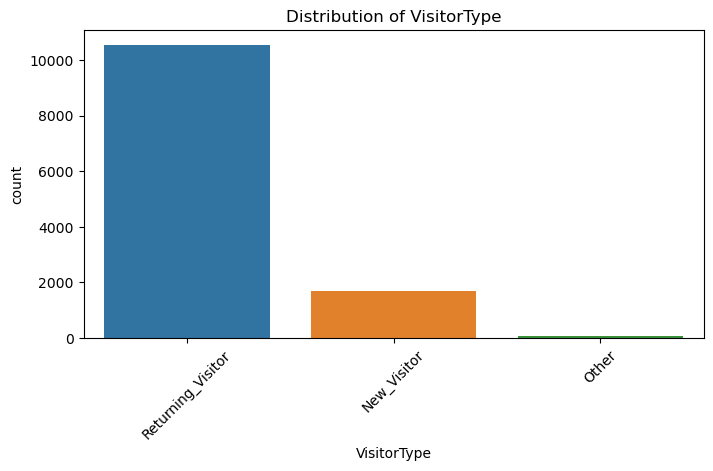

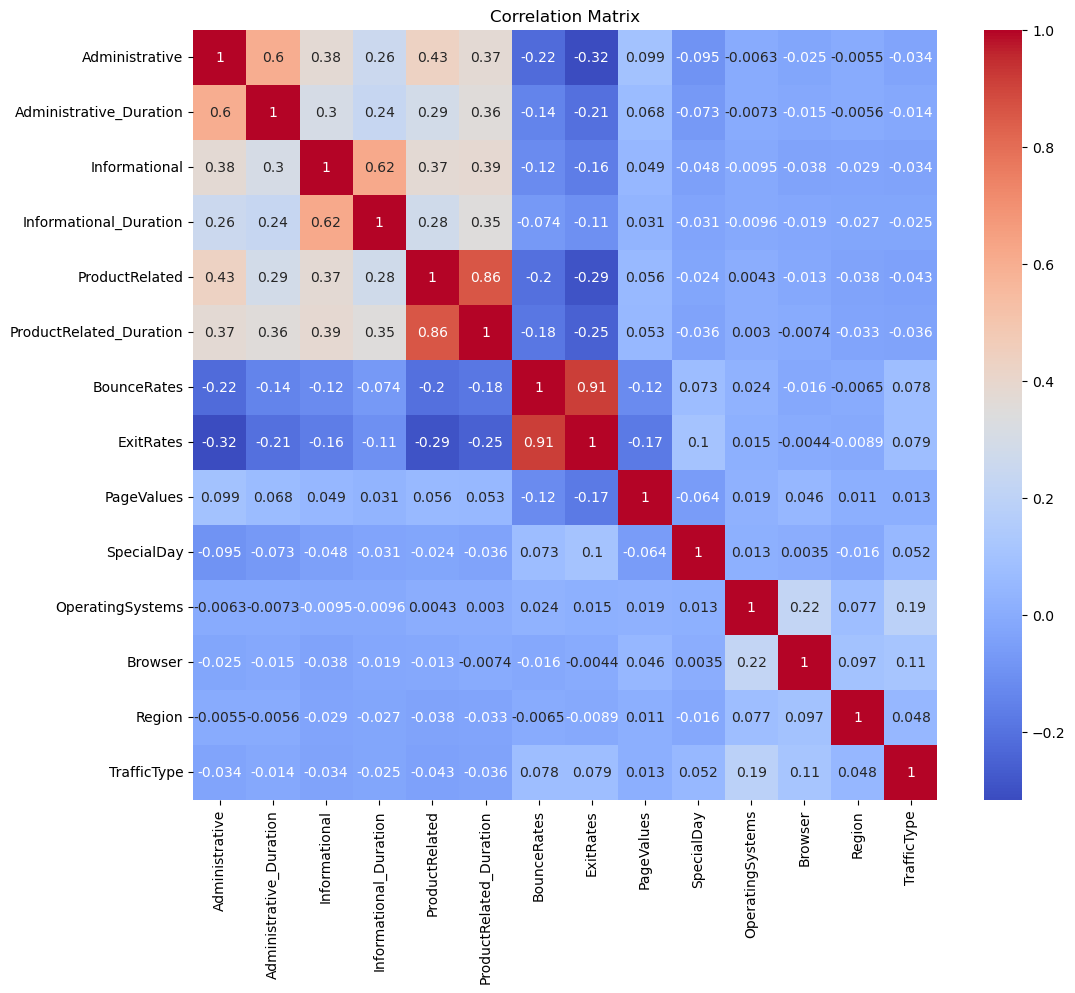

Cluster Centers (Feature Means):
   Administrative  Administrative_Duration  Informational  \
0        1.713516                51.176071       0.215381   
1        7.352797               308.085352       2.528580   
2        0.048341                 1.414092       0.016114   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                8.137938       23.911381               875.244677   
1              212.927256       96.685310              3827.411932   
2                0.092133        3.075829                56.550739   

   BounceRates  ExitRates    PageValues  SpecialDay  OperatingSystems  \
0     0.009144   0.032070  5.889675e+00    0.061443          2.120129   
1     0.006284   0.019440  9.705572e+00    0.029625          2.111248   
2     0.166040   0.180137 -4.440892e-15    0.110332          2.179147   

    Browser    Region  TrafficType  
0  2.384639  3.194341     4.045087  
1  2.220037  2.927474     3.602336  
2  2.316588  3.056872     5.014218  


C:\Users\ASUS\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


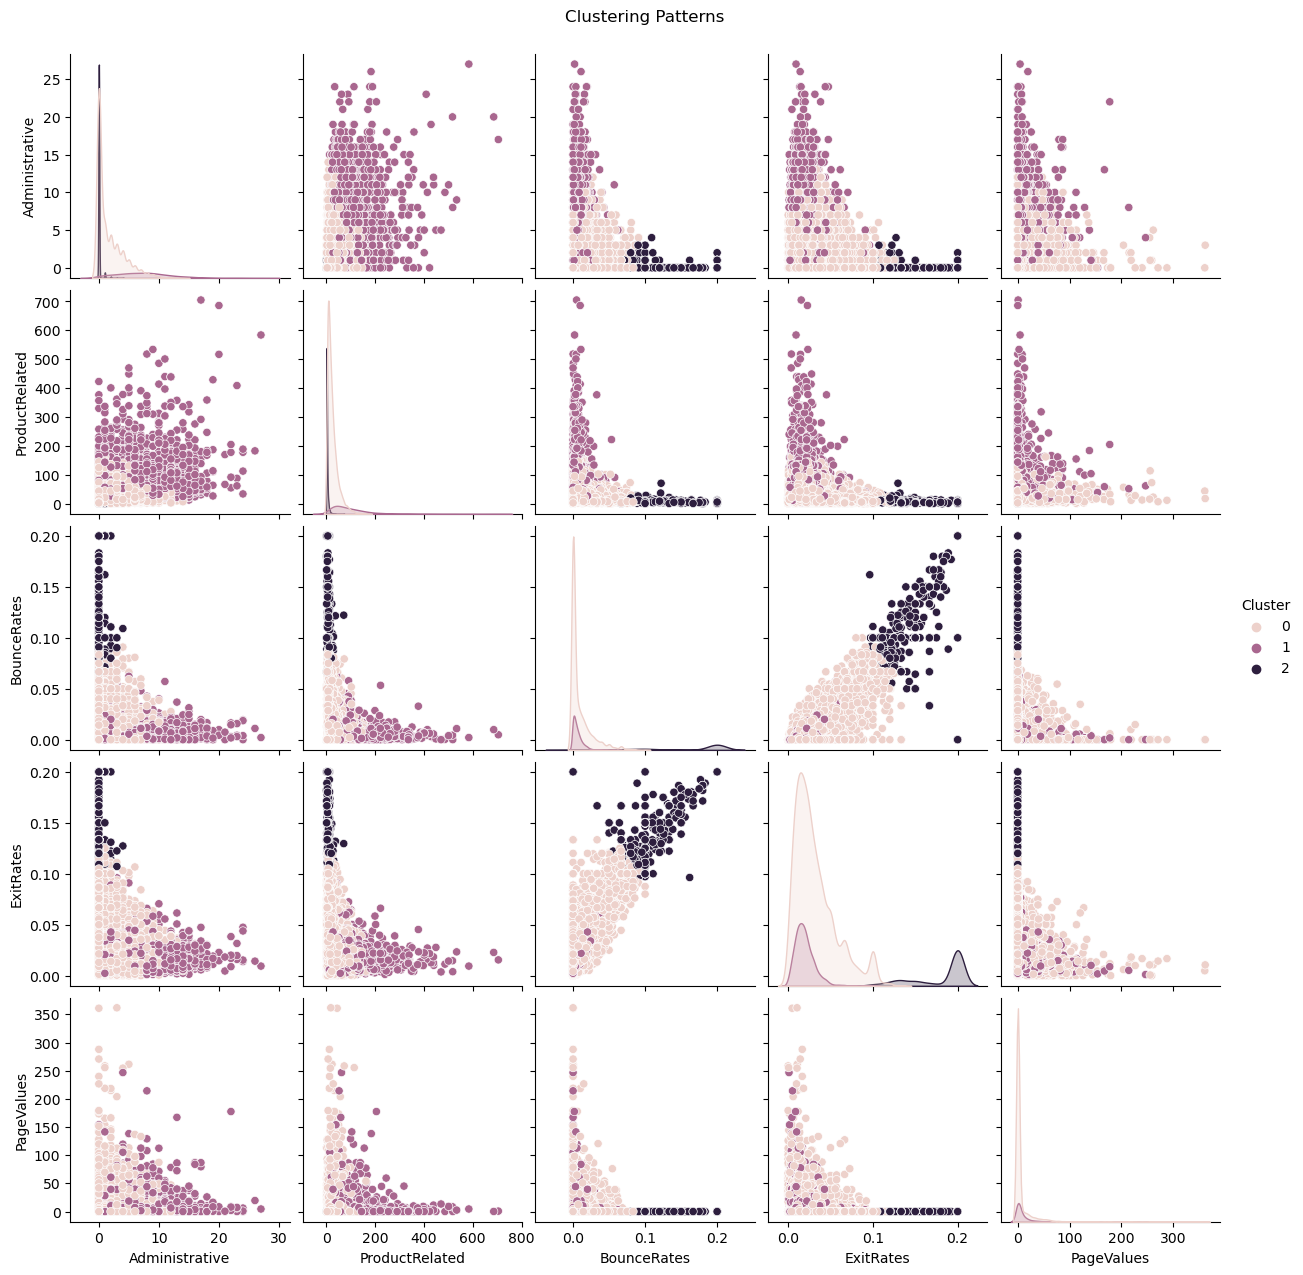

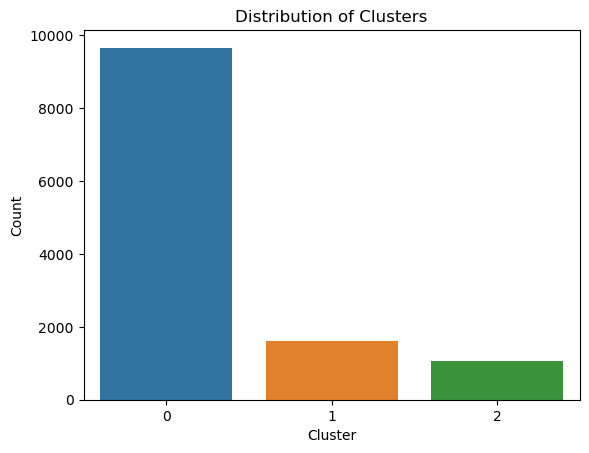

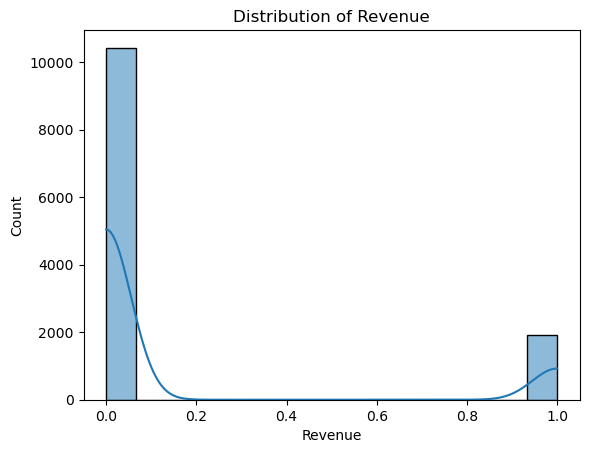

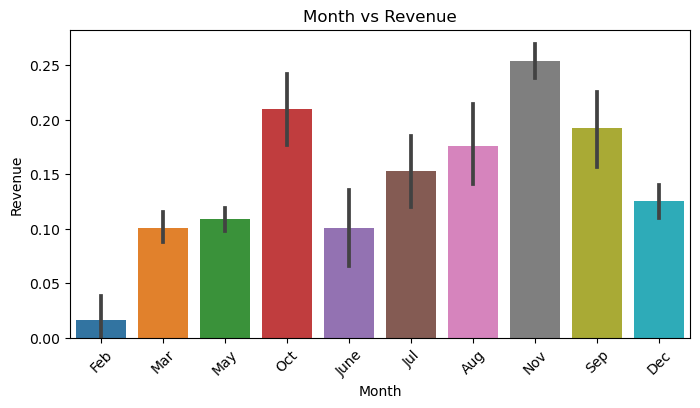

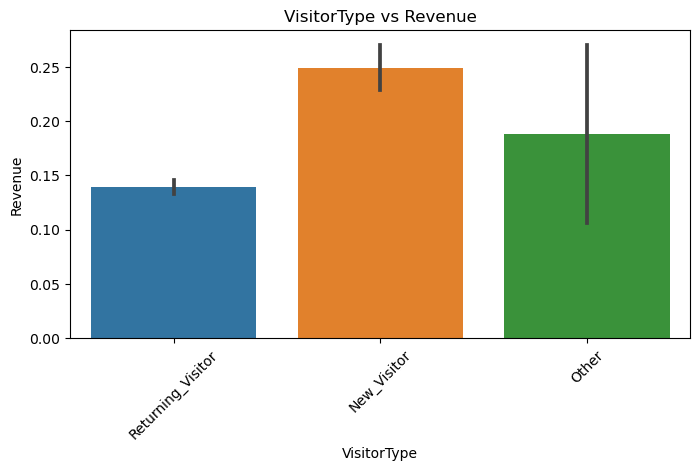

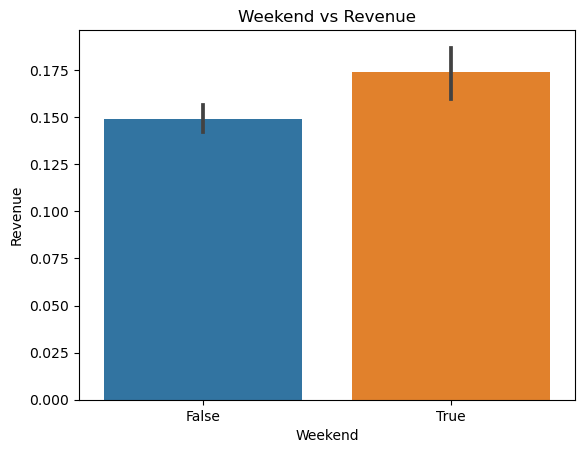

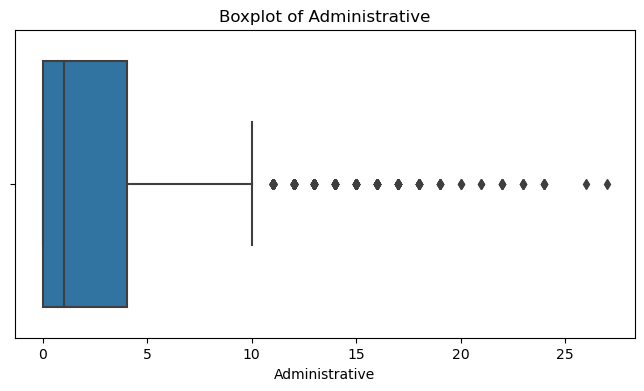

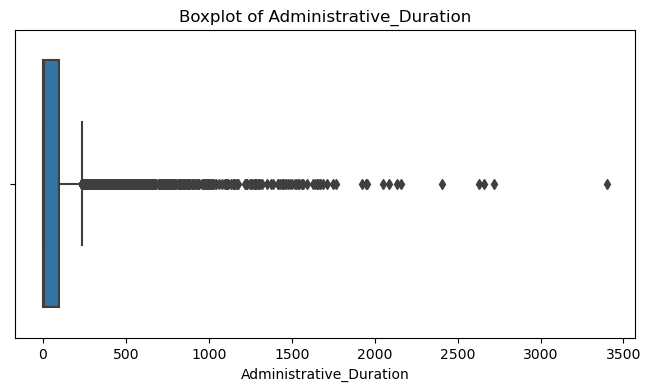

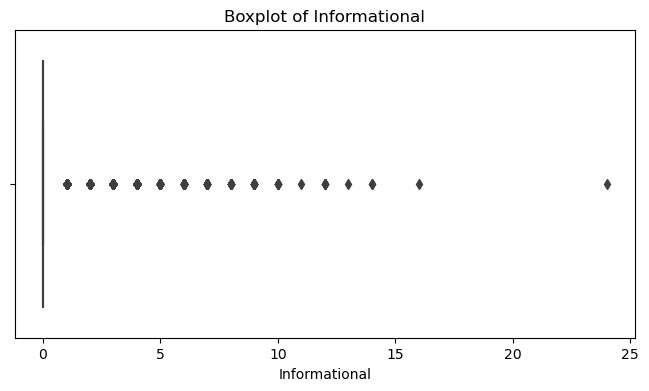

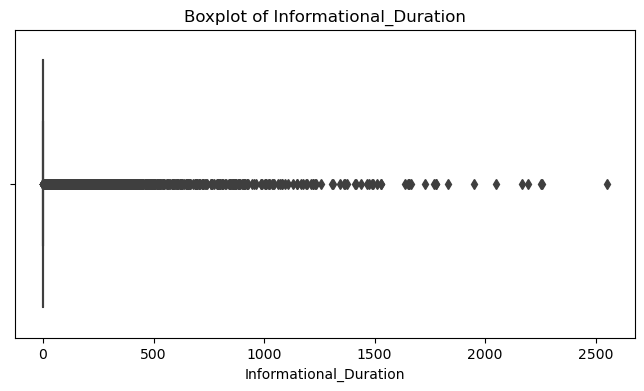

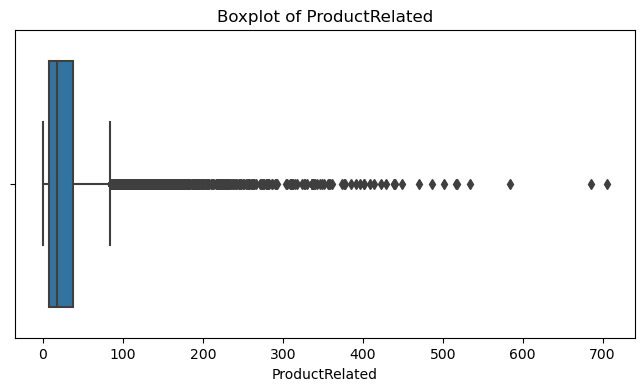

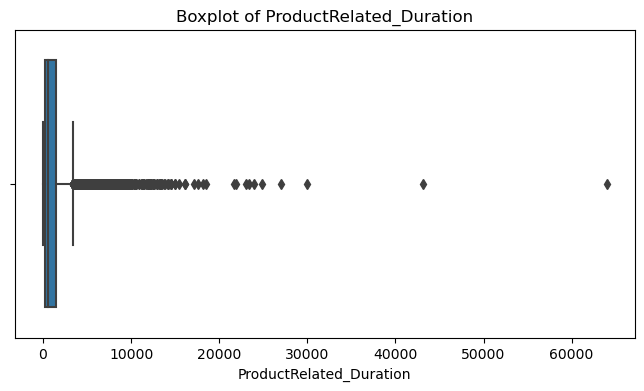

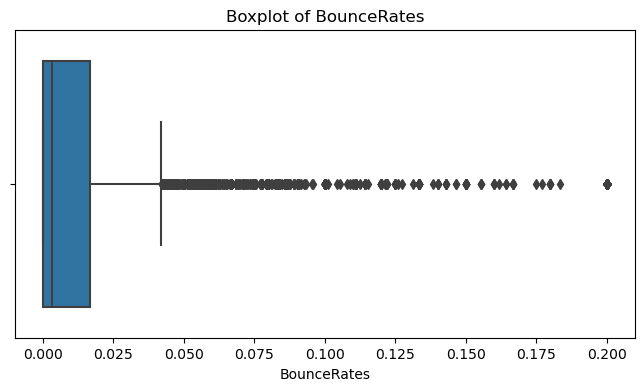

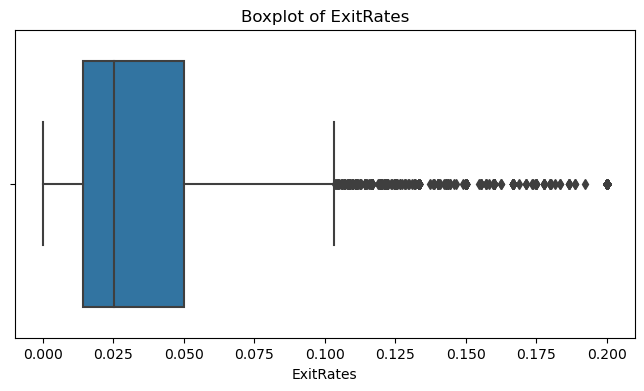

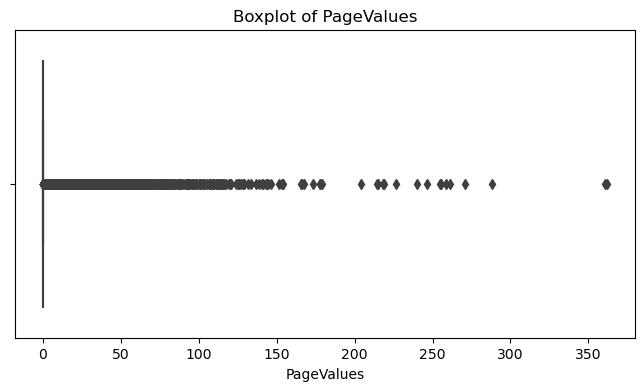

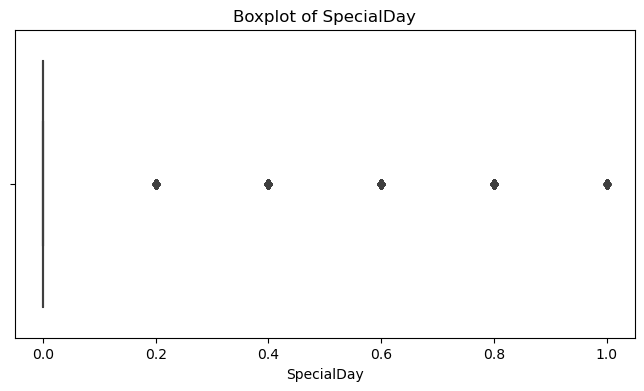

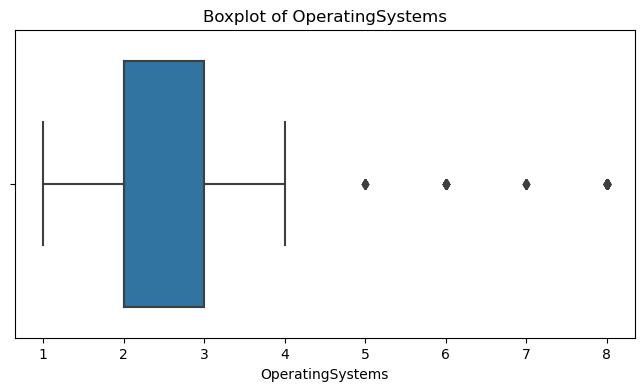

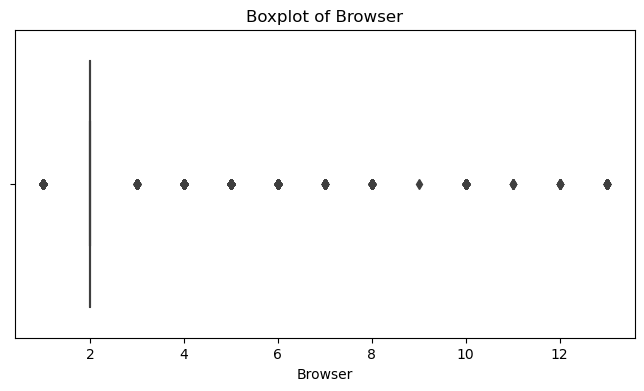

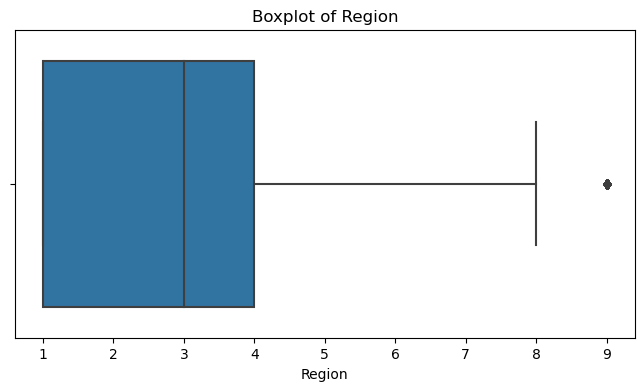

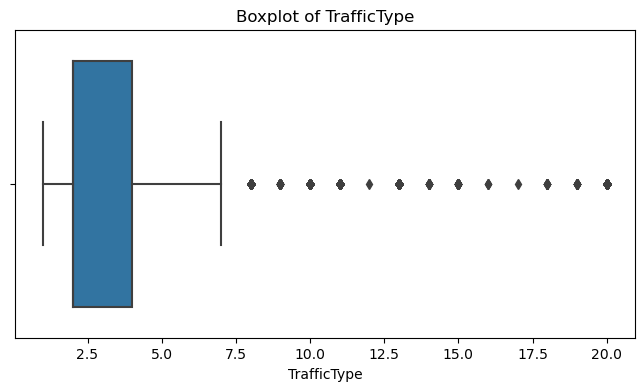

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils import resample

# Loading the dataset
file_path = 'online_shoppers_intention.csv'
cb = pd.read_csv(file_path)

# Displaying basic informations
print(cb.head())
print(cb.info())
print(cb.describe())
print("Percentage of Missing Values: {:.2f}%".format((cb.isnull().sum().sum() / cb.size) * 100))

# Displaying the unique values in categorical columns
for col in cb.select_dtypes(include='object').columns:
    print(f"{col}: {cb[col].unique()}")

# Visualizing numerical features
cb.hist(figsize=(12, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Visualizing categorical features
for col in cb.select_dtypes(include='object').columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=cb, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

# Correlation Matrix
numeric_cb = cb.select_dtypes(include='number')
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_cb.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Preprocessing: One-Hot Encoding and Standardizing
cb_encoded = pd.get_dummies(cb, columns=['Month', 'VisitorType'], drop_first=True)
numerical_features = cb_encoded.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
cb_encoded[numerical_features] = scaler.fit_transform(cb_encoded[numerical_features])

# Clustering using KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
cb['Cluster'] = kmeans.fit_predict(cb_encoded[numerical_features])

# Displaying cluster centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=numerical_features)
print("Cluster Centers (Feature Means):")
print(cluster_centers)

# Visualizing Clustering Patterns
sns.pairplot(cb, hue='Cluster', vars=['Administrative', 'ProductRelated', 'BounceRates', 'ExitRates', 'PageValues'])
plt.suptitle('Clustering Patterns', y=1.02)
plt.show()

# Distribution of Clusters
sns.countplot(x='Cluster', data=cb)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Revenue Analysis
cb['Revenue'] = cb['Revenue'].astype(int)
sns.histplot(cb['Revenue'], kde=True)
plt.title('Distribution of Revenue')
plt.show()

# Addressing Class Imbalance Using Upsampling
cb_majority = cb_encoded[cb_encoded['Revenue'] == 0]
cb_minority = cb_encoded[cb_encoded['Revenue'] == 1]

cb_minority_upsampled = resample(
    cb_minority,
    replace=True,
    n_samples=len(cb_majority),
    random_state=42
)

cb_balanced = pd.concat([cb_majority, cb_minority_upsampled])

# Categorical Features vs Revenue
for col in cb.select_dtypes(include='object').columns:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=col, y='Revenue', data=cb)
    plt.title(f'{col} vs Revenue')
    plt.xticks(rotation=45)
    plt.show()

# Weekend vs Revenue Analysis
sns.barplot(x='Weekend', y='Revenue', data=cb)
plt.title('Weekend vs Revenue')
plt.show()

# Boxplot for Numerical Features
for col in cb.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=cb[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [103]:
# Mapping Month to numerical values
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cb['Month_Num'] = cb['Month'].map(month_mapping)

# Adding feature for Q4 (higher shopping season)
cb['Is_Q4'] = cb['Month_Num'].apply(lambda x: 1 if x in [10, 11, 12] else 0)


# Interaction ratios
cb['Bounce_Exit_Ratio'] = cb['BounceRates'] / (cb['ExitRates'] + 1e-5)  # Avoid division by zero
cb['Info_Product_Ratio'] = cb['Informational_Duration'] / (cb['ProductRelated_Duration'] + 1e-5)


# Combining engagement durations
cb['Engagement_Index'] = (cb['Administrative_Duration'] + 
                          cb['Informational_Duration'] + 
                          cb['ProductRelated_Duration'])


cb['Total_Actions'] = cb['Administrative'] + cb['Informational'] + cb['ProductRelated']

cb['Impulsive_Shop_Indicator'] = cb['Weekend'].astype(int) + cb['SpecialDay']

# Calculating revenue probabilities by month
monthly_revenue_prob = cb.groupby('Month_Num')['Revenue'].mean().to_dict()
cb['Monthly_Revenue_Prob'] = cb['Month_Num'].map(monthly_revenue_prob)

In [105]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np

# Defining the features (X) and target (y) from the balanced dataset
X = cb_balanced.drop(columns=['Revenue'])  # Features
y = cb_balanced['Revenue']                 # Target

# Spliting dataset into Train-Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,                 # 80-20 split
    random_state=42,              # Ensures reproducibility
    stratify=y                    # Preserves target distribution
)


# Cross-Validation 
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Parameters Found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Optimized Random Forest Classifier Performance Metrics:
Accuracy: 0.96
Precision: 0.94
Recall: 0.99
F1 Score: 0.96
ROC-AUC Score: 1.00


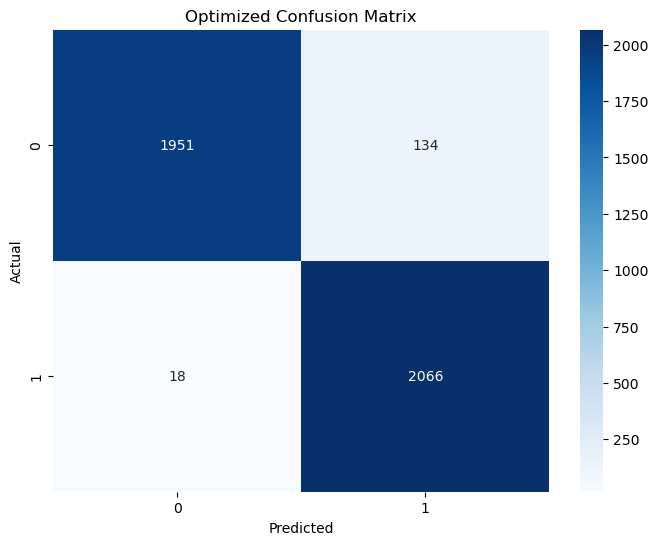

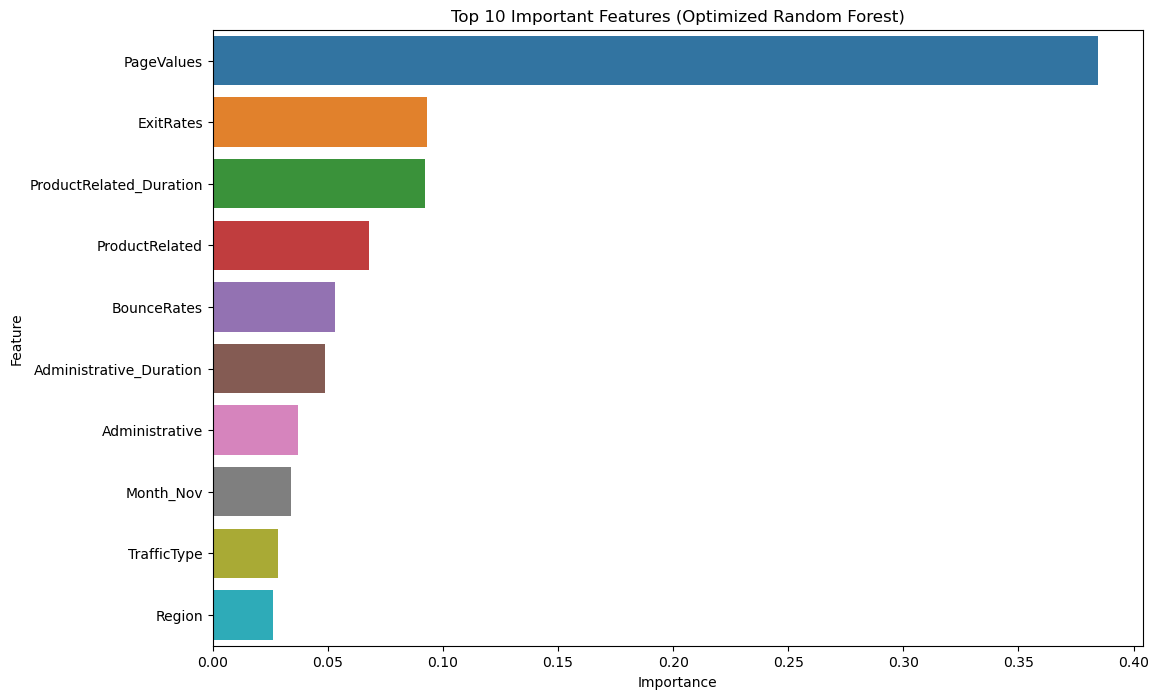

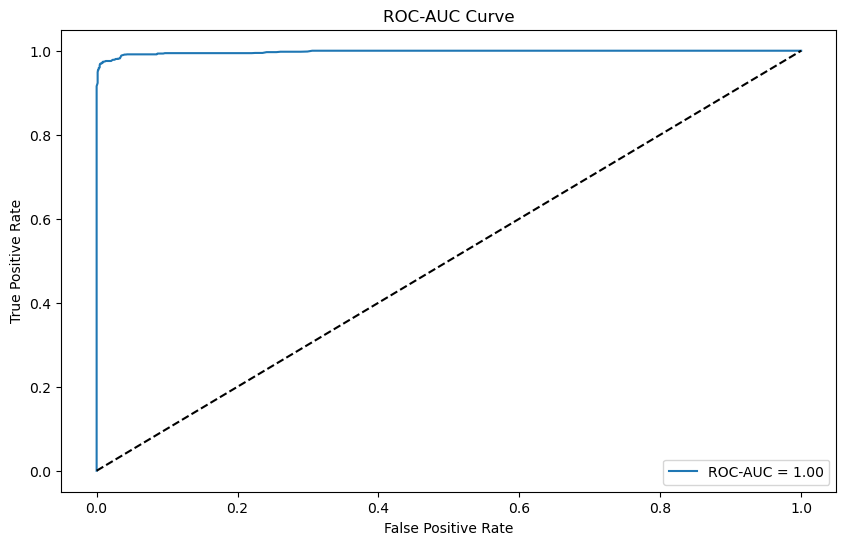


Optimized Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.94      0.96      2085
        True       0.94      0.99      0.96      2084

    accuracy                           0.96      4169
   macro avg       0.96      0.96      0.96      4169
weighted avg       0.96      0.96      0.96      4169



In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# Defining the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42, class_weight='balanced')

# Defining the parameter grid for optimization
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [10, 20, None],           # Tree depth
    'min_samples_split': [2, 5, 10],       # Minimum samples for node split
    'min_samples_leaf': [1, 2, 4]          # Minimum samples per leaf node
}

# Performing Grid Search with 5-fold cross-validation
grid_Search = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',    
    verbose=2,
    n_jobs=-1
)

# Fiting Grid Search on Training Data
grid_Search.fit(X_train, y_train)

# Best parameters and estimator
best_params = grid_Search.best_params_
best_estimator = grid_Search.best_estimator_

print("\nBest Parameters Found:", best_params)

# Evaluating the Optimized Model
y_pred = best_estimator.predict(X_test)
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nOptimized Random Forest Classifier Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Optimized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_estimator.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Important Features (Optimized Random Forest)')
plt.show()

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

# Classification Report
print("\nOptimized Classification Report:\n", classification_report(y_test, y_pred))


In [82]:
!pip install scikit-learn==1.4.2



Best number of boosting rounds: 200

Optimized XGBoost Classifier Performance Metrics:
Accuracy: 0.92
Precision: 0.90
Recall: 0.94
F1 Score: 0.92
ROC-AUC Score: 0.97


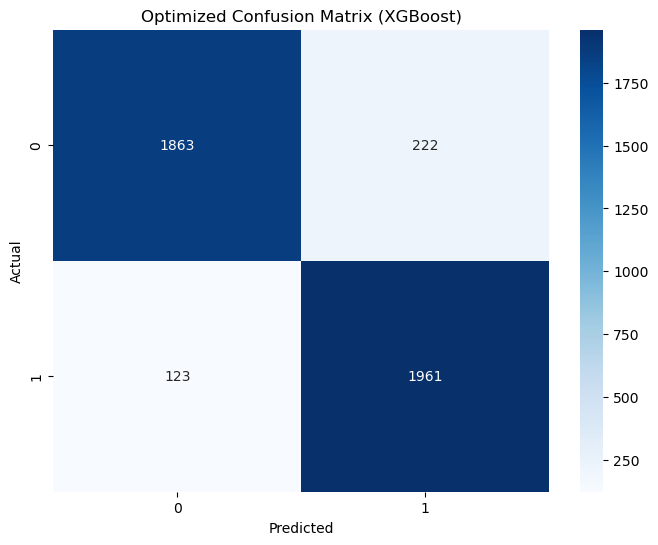

<Figure size 1200x800 with 0 Axes>

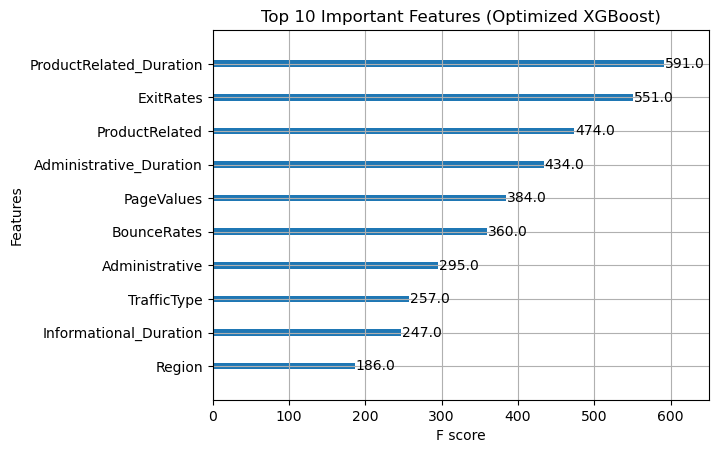

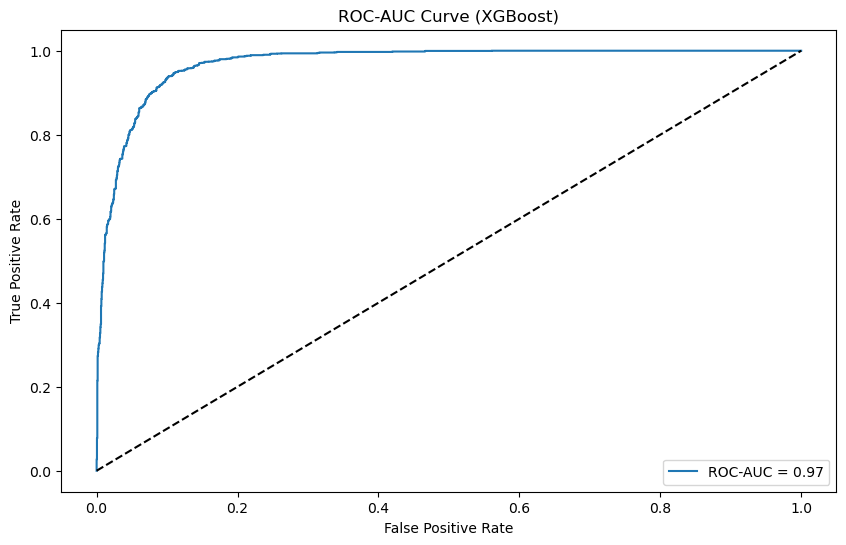


Optimized Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.89      0.92      2085
        True       0.90      0.94      0.92      2084

    accuracy                           0.92      4169
   macro avg       0.92      0.92      0.92      4169
weighted avg       0.92      0.92      0.92      4169



In [119]:
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
# Defining XGBoost Classifier parameters
param_grid = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',       # Loss function
    'eta': 0.1,                     # Learning rate
    'max_depth': 5,                 # Depth of trees
    'subsample': 0.8,               # Fraction of data to use
    'colsample_bytree': 0.8,        # Fraction of features to use
    'seed': 42                      # Reproducibility
}

# Cross-Validation with Early Stopping
dtrain = xgb.DMatrix(X_train, label=y_train)
cv_results = xgb.cv(
    params=param_grid,
    dtrain=dtrain,
    num_boost_round=200,       # Maximum boosting rounds
    nfold=5,                   # 5-Fold CV
    stratified=True,           # Preserve class proportions
    early_stopping_rounds=10,  # Stop if no improvement
    metrics='logloss',         # Metric to optimize
    seed=42
)

# Best number of boosting rounds
best_num_boost_round = len(cv_results)
print(f"\nBest number of boosting rounds: {best_num_boost_round}")

# Training Final XGBoost Model
final_model = xgb.train(
    params=param_grid,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round
)

# Evaluating the Model
dtest = xgb.DMatrix(X_test)
y_pred_proba = final_model.predict(dtest)
y_pred = np.round(y_pred_proba)  # Binary Predictions

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nOptimized XGBoost Classifier Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Optimized Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting Feature Importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, importance_type='weight', max_num_features=10)
plt.title('Top 10 Important Features (Optimized XGBoost)')
plt.show()

# Plotting ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve (XGBoost)')
plt.legend(loc='lower right')
plt.show()

# Classification Report
print("\nOptimized Classification Report:\n", classification_report(y_test, y_pred))


Epoch 1/100


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7575 - loss: 0.5090 - val_accuracy: 0.8336 - val_loss: 0.3872
Epoch 2/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8314 - loss: 0.3798 - val_accuracy: 0.8462 - val_loss: 0.3559
Epoch 3/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8450 - loss: 0.3566 - val_accuracy: 0.8489 - val_loss: 0.3403
Epoch 4/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8456 - loss: 0.3522 - val_accuracy: 0.8543 - val_loss: 0.3301
Epoch 5/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8537 - loss: 0.3326 - val_accuracy: 0.8564 - val_loss: 0.3274
Epoch 6/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8504 - loss: 0.3396 - val_accuracy: 0.8651 - val_loss: 0.3209
Epoch 7/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8569 - loss: 0.3216 - val_accuracy: 0.8606 - val_loss: 0.3145
Epoch 8/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8618 - loss: 0.3178 - val_accuracy: 0.8639

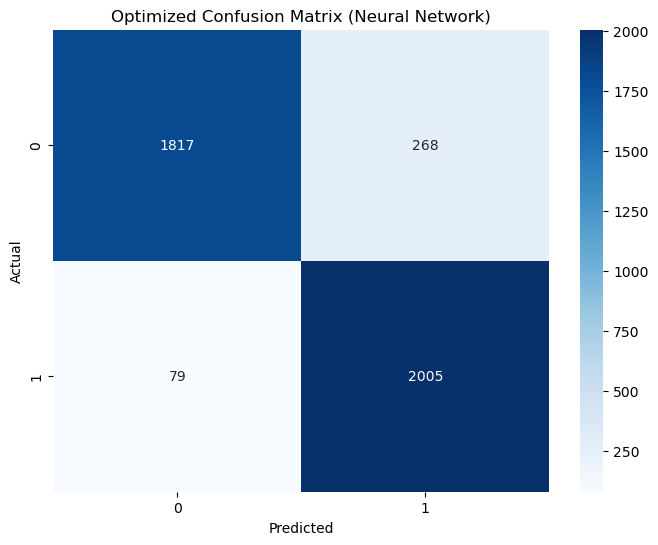

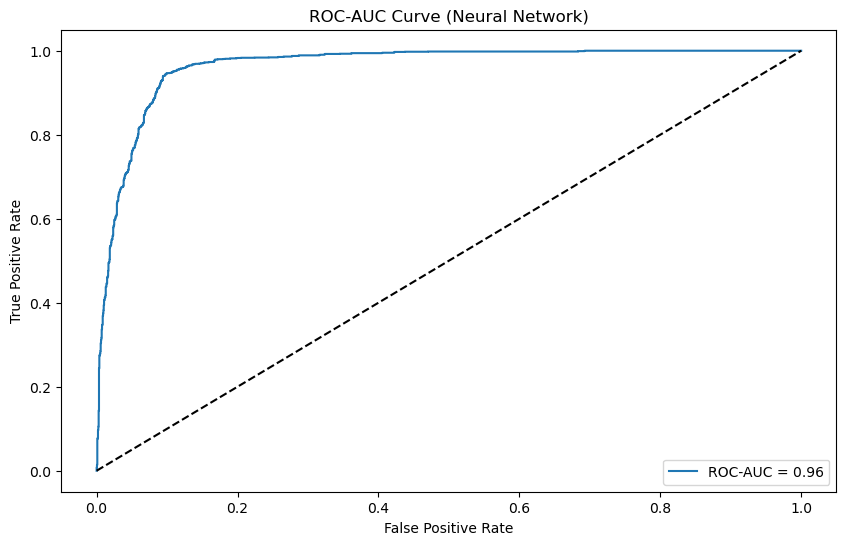


Optimized Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.87      0.91      2085
        True       0.88      0.96      0.92      2084

    accuracy                           0.92      4169
   macro avg       0.92      0.92      0.92      4169
weighted avg       0.92      0.92      0.92      4169



In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

# Defining Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')  
])

# Compiling the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=5,              
    restore_best_weights=True  
)

# Training the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluating the Model on Test Data
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Model Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)

print("\nOptimized Neural Network Classifier Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")

# PLotting Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Optimized Confusion Matrix (Neural Network)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve (Neural Network)')
plt.legend(loc='lower right')
plt.show()

# Classification Report
print("\nOptimized Classification Report:\n", classification_report(y_test, y_pred))
